# Machine learning german bank credit risk prediction
In this project, I will build a <b>machine learning model for credit risk prediction of German bank customers</b>. It involves <b>supervised learning (using a labeled training set) for classification</b>, where the <b>target</b> is <b>1</b> if the <b>customer</b> represents a <b>bad risk</b>, and <b>0</b> if they represent a <b>good risk</b>.

I will use the following <b>pipeline:</b>

<b>1. Define the business problem.</b><br>
<b>2. Collect the data and get a general overview of it.</b><br>
<b>3. Split the data into train and test sets.</b><br>
<b>4. Explore the data (exploratory data analysis)</b><br>
<b>5. Data cleaning and preprocessing.</b><br>
<b>6. Model training, comparison, selection and tuning.</b><br>
<b>7. Final production model testing and evaluation.</b><br>
<b>8. Conclude and interpret the model results.</b><br>

In <b>this notebook</b>, I will perform <b>machine learning modelling, covering steps 5 to 8 of the pipeline above</b>. The main <b>objective</b> here is to <b>build a model that can predict as many as possible bad risk customers, thus recall is the metric of interest</b>. Once I build this model, the <B>bank can make informed decisions that balance profit generation with prudent risk management</b>, ultimately benefiting both the company and its customers. Furthermore, I will approach these steps in more detail below, with an overview of them and the explanation of why I am making each decision. 

### Importing the libraries

In [61]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.base import clone

# Fixing bayesian search error.
np.int = int

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

# Utils
from notebooks.modelling_utils import *

### Reading the dataset

In [62]:
df = pd.read_csv('data/german_credit_data.csv')
# Dropping irrelevant column.
df.drop(columns=['Unnamed: 0'], inplace=True)

In [63]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


Sex and Risk can be expressed as binary features. Thus, I will set good as 1 and bad as 0 in Risk. In sex, I will set male as 1 and female as 0.

In [64]:
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
df['Risk'] = df['Risk'].map({'bad': 1, 'good': 0})

### Split the data into train and test sets
- First of all, I will split the data into train and test sets.
- Test set is supposed to be data the model has never seen before.
- This split will avoid data leakage, which occurs when information from the test set or future data inadvertently leaks into the training process, leading to over-optimistic performance estimate, compromising the model's ability to generalize to new, unseen data.
- A good practice to protect the model against data leakage is perform fit_transform on training data and just transform on test data when applying preprocessing steps after the split.
- I will specify stratify=y so that the train_test_split function ensures that the splitting process maintains the same percentage of each target class in both the training and testing sets. This is particularly useful when dealing with imbalanced datasets, which is the case, as there are more bad risk customers.

In [65]:
X = df.drop(columns=['Risk'])
y = df['Risk'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [66]:
print(f'Train predictor dataset shape: {X_train.shape}.')
print(f'Train target dataset shape: {y_train.shape}.')
print(f'Test predictor dataset shape: {X_test.shape}.')
print(f'Test target dataset shape: {y_test.shape}.')

Train predictor dataset shape: (800, 9).
Train target dataset shape: (800,).
Test predictor dataset shape: (200, 9).
Test target dataset shape: (200,).


In [67]:
print(f'Train target classes proportions: ')
print(y_train.value_counts(normalize=True))
print(f'\nTest target classes proportions:')
print(y_test.value_counts(normalize=True))

Train target classes proportions: 
Risk
0    0.7
1    0.3
Name: proportion, dtype: float64

Test target classes proportions:
Risk
0    0.7
1    0.3
Name: proportion, dtype: float64


The train-test-split was succesfull and each target class proportion was preserved in both sets.

# 5. Data cleaning and preprocessing
In order to fit machine learning algorithms, it is necessary to apply some transformations to the data.

- <b>Impute missing values:</b> There are some missing values in Saving accounts and Checking account. I will replace them with mode. Dropping the null values is not a good choice because I have a little amount of data (just 1000 rows).<br>
- <b>Outliers:</b> In the eda step, I investigated the outliers and saw that they don't represent inconsistent information like measurement errors. Thus, considering this and the fact that I have a little amount of data, I will not drop or treat any.<br>
- In order to train tree-based algorithms, it is not necessary to scale the data. However, as I intend to test a different algorithms, I will apply standard scaler on numerical and categorical features (after encoding). By doing this, it will be possible to compare all models at once.
- <b>Numerical features:</b> Some algorithms are sensitive to feature scaling because they use distance calculations or optimizations like gradient descent for being trained, which are affected by scale. Thus, I will apply StandardScaler on numeric attributes.<br>
- <b>Categorical features:</b> Machine learning algorithms make mathematical calculations, so it's necessary to convert the categoric attributes to numeric by applying encoding techniques. Saving accounts and Checking account present ordinal relationships. Thus, I chose OrdinalEncoder for encoding them. Moreover, I chose TargetEncoder for the other categorical features because OneHotEncoder would increase dimensionality (creating dummy variables). As I have a little amount of data, increase dimensionality would favor overfitting, compromising my model's generalization ability. After all these variables are encoded/converted to numeric, I will apply StandardScaler because some algorithms are sensitive to scale. StandardScaler is more robust to outliers than MinMaxScaler, that's why I chose it.<br>

In [68]:
X_train.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
828,47,1,2,free,NaN,little,8335,36,car
997,38,1,2,own,little,NaN,804,12,radio/TV
148,28,1,2,own,little,little,5371,36,furniture/equipment
735,29,0,0,own,NaN,moderate,3990,36,domestic appliances
130,24,0,2,own,NaN,moderate,8487,48,car


Checking missing values.

In [69]:
X_train.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     144
Checking account    316
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Checking numerical features.

In [70]:
numerical_features = X_train.select_dtypes('number').columns.to_list()
print(f'There are {len(numerical_features)} numerical features. They are: {numerical_features}')

There are 5 numerical features. They are: ['Age', 'Sex', 'Job', 'Credit amount', 'Duration']


Checking categorical features cardinality and unique values.

In [71]:
categorical_features = X_train.select_dtypes('object').columns.to_list()

print(f'There are {len(categorical_features)} categorical features. They are: {categorical_features}')
print()

for feature in categorical_features:
    print(feature)
    print(f'Number of categories: {X_train[feature].nunique()}. They are:')
    print(X_train[feature].unique())
    print()

There are 4 categorical features. They are: ['Housing', 'Saving accounts', 'Checking account', 'Purpose']

Housing
Number of categories: 3. They are:
['free' 'own' 'rent']

Saving accounts
Number of categories: 4. They are:
[nan 'little' 'moderate' 'rich' 'quite rich']

Checking account
Number of categories: 3. They are:
['little' nan 'moderate' 'rich']

Purpose
Number of categories: 8. They are:
['car' 'radio/TV' 'furniture/equipment' 'domestic appliances' 'education'
 'repairs' 'vacation/others' 'business']



I will build the preprocessor below. As I intend to test different algorithms, the same preprocessor will be used for tree-based models and scale sensitive models. Moreover, I will apply the techniques that I've mentioned above.

In [72]:
target_encoder_features = ['Saving accounts', 'Checking account']
ordinal_encoder_features = ['Purpose', 'Housing']

In [73]:
ordinal_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), 
        ('ordinal_encoder', OrdinalEncoder()),
        ('std_scaler', StandardScaler())
        ]
        )

target_pipeline = Pipeline(
    steps=[
        ('target_encoder',TargetEncoder(cols=target_encoder_features)), 
        ('std_scaler', StandardScaler())
        ]
        )

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_pipeline, ordinal_encoder_features),
        ('target', target_pipeline, target_encoder_features),
        ('std_scaler', StandardScaler(), numerical_features)
        ], remainder='passthrough'
        )

In [74]:
X_train_prepared = preprocessor.fit_transform(X_train, y_train)
X_train_prepared.shape

(800, 9)

# 6. Model training, comparison, selection and tuning
- In this step, I intend to compare different models performances. In order to achieve this, I will use stratified k-fold cross validation to train each one of them and evaluate their ROC-AUC score. Accuracy is not a good metric because the target is imbalanced. Moreover, stratified k-fold cross validation will maintain the target proportion on each fold, dealing with the imbalanced target as well.
- <b>K-fold cross-validation</b> is a technique used in machine learning to assess the performance of a model. It involves dividing the dataset into K subsets, using K-1 for training and one for testing iteratively. This helps in estimating a model's generalization ability by reducing the risk of overfitting and providing more reliable performance metrics.<br>
- My objective here is to select a best model to go for hyperparameter tuning. In order to get this best model, I will evaluate the highest roc-auc average validation scores and look at the bias-variance trade-off.
- After selecting a model, I will tune its hyperparameters.
<br>
- <b>Hyperparameter tuning</b> refers to the process of selecting the optimal hyperparameters for a machine learning model. Hyperparameters are parameters that are set before the model is trained and directly influence its performance but are not learned from the data.

Training the models and comparing their performances (roc-auc score) with stratified k-fold cross validation in order to choose one of them for hyperparameter tuning.

In [75]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear SVM': LinearSVC(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

Logistic Regression results: 
--------------------------------------------------
Training score: 0.6407738095238096
Average validation score: 0.7561755952380952
Standard deviation: 0.05039534545754632
Training time: 0.00499 seconds

Linear SVM results: 
--------------------------------------------------
Training score: 0.637202380952381
Average validation score: 0.755766369047619
Standard deviation: 0.04842001000888174
Training time: 0.02943 seconds

SVM results: 
--------------------------------------------------
Training score: 0.687797619047619
Average validation score: 0.7375744047619048
Standard deviation: 0.03108445380154829
Training time: 0.01696 seconds

K-Nearest Neighbors results: 
--------------------------------------------------
Training score: 0.7413690476190476
Average validation score: 0.6764508928571429
Standard deviation: 0.05469140357990755
Training time: 0.002 seconds



Random Forest results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.7517299107142857
Standard deviation: 0.0502646227554313
Training time: 0.28725 seconds

XGBoost results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.7303943452380952
Standard deviation: 0.03350705918142098
Training time: 0.09997 seconds

Plotting the results: 


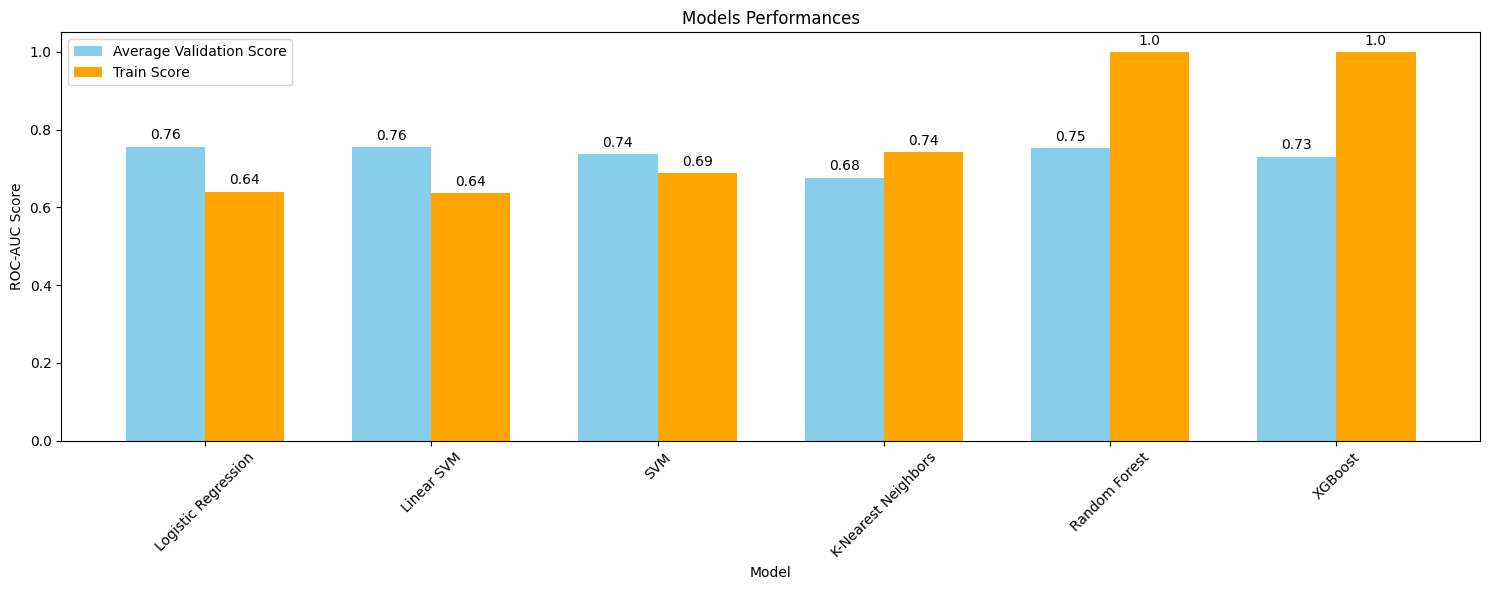

In [76]:
eval_df = evaluate_models_cv(models=models, X_train=X_train_prepared, y_train=y_train)

In [77]:
eval_df.sort_values(['Average Val Score'], ascending=False)

,Model,Average Val Score,Train Score
0,Logistic Regression,0.756176,0.640774
1,Linear SVM,0.755766,0.637202
4,Random Forest,0.751730,1.000000
2,SVM,0.737574,0.687798
5,XGBoost,0.730394,1.000000
3,K-Nearest Neighbors,0.676451,0.741369


Logistic Regression presents the highest average validation ROC-AUC score. Furthermore, Random Forest is overfitting. There is a significant difference between its validation and training errors. In fact, the training error is zero. Thus, the Random Forest model exhibits low bias and high variance, and since its mean validation score is only slightly lower than that of Logistic Regression, I will choose it for hyperparameter tuning and final model evaluation because there is more room for performance improvement (due to the overfit).

### Hyperparameter tuning
As I intend to tune Random Forest model, I won't use GridSearchCV.

<b>Why not use grid search?</b> 
- Using grid search CV to tune Random Forest can be problematic due to its computational expense, limitations in granularity and adaptability, lack of consideration for interaction effects, inefficient exploration of the hyperparameter space, and inefficient allocation of computational resources. 
- Grid search exhaustively searches through all combinations of specified hyperparameters, it does not adapt its search based on the observed performance of previous hyperparameter configurations. Also, hyperparameters in Random Forest can have complex interactions, where the impact of one hyperparameter depends on the values of others. Grid search does not explicitly consider these interactions and evaluates hyperparameters independently. 
<br>

Considering this, I will tune Random Forest using Bayesian Optimization.

<b>What is Bayesian Optimization?</b>
-  Bayesian optimization is an efficient and adaptive technique for finding the optimal combination of hyperparameters for a machine learning model. It uses probabilistic models to intelligently explore the hyperparameter space, balancing exploration and exploitation.

An important point here is to define class_weight hyperparameter. Then, the algorithm will assign different weights for the target's minority (bad risk) and majority (good risk) class instances. Thus, the model will be penalized when mistakenly predicting a bad risk customer and also be able to better learn the patterns in minority class data samples.

In [78]:
n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

search_space = {
    'n_estimators': Integer(100, 700),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'max_depth': Integer(2, 16),
    'min_samples_split': Integer(2, 50),
    'min_samples_leaf': Integer(2, 25),
    'bootstrap': Categorical([True, False]),
    'class_weight': Categorical(['balanced', 'balanced_subsample']),
    'max_features': Categorical(['sqrt', 'log2', None])
}

bayesian_search = BayesSearchCV(estimator=RandomForestClassifier(), search_spaces=search_space, cv=stratified_kfold, n_iter=50, scoring='roc_auc', return_train_score=True, random_state=42)

In [79]:
bayesian_search.fit(X_train_prepared, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=RandomForestClassifier(), random_state=42,
              return_train_score=True, scoring='roc_auc',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'class_weight': Categorical(categories=('balanced', 'balanced_subsample'), prior=None),
                             'criterion': Categorical(...
                             'max_depth': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2', None), prior=None),
                             'min_samples_leaf': Integer(low=2, high=25, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=50, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=700, prior='uniform', transform='normalize')})

In [80]:
print(f'The best params fund for Random Forest are: ')
bayesian_search.best_params_

The best params fund for Random Forest are: 


OrderedDict([('bootstrap', True),
             ('class_weight', 'balanced_subsample'),
             ('criterion', 'log_loss'),
             ('max_depth', 8),
             ('max_features', 'log2'),
             ('min_samples_leaf', 7),
             ('min_samples_split', 2),
             ('n_estimators', 322)])

Let's take a look into some results obtained by the bayesian search cv, specially for important parameters like class_weight, criterion, max_depth, min_samples_leaf, min_samples_split and n_estimators.

In [81]:
bayesian_search_results = pd.DataFrame(bayesian_search.cv_results_)
bayesian_search_results = bayesian_search_results[['rank_test_score', 'mean_test_score', 
'mean_train_score', 'param_class_weight', 
'param_criterion', 'param_max_depth', 
'param_min_samples_leaf', 'param_min_samples_split', 
'param_n_estimators']]
bayesian_search_results.sort_values(['rank_test_score']).head(10)

,rank_test_score,mean_test_score,mean_train_score,param_class_weight,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators
35,1,0.767150,0.827660,balanced_subsample,entropy,16,20,50,663
8,1,0.767150,0.902753,balanced_subsample,log_loss,8,7,2,322
47,3,0.766741,0.851702,balanced_subsample,log_loss,10,9,47,700
14,4,0.766629,0.850498,balanced,gini,12,15,19,521
31,5,0.766518,0.819402,balanced_subsample,entropy,8,25,2,100
43,6,0.766481,0.896615,balanced,entropy,11,5,27,694
41,7,0.765923,0.886523,balanced,entropy,16,3,36,446
29,8,0.765774,0.828988,balanced_subsample,entropy,16,21,2,177
6,9,0.765662,0.844864,balanced_subsample,gini,14,16,33,353
13,10,0.765588,0.845575,balanced,log_loss,7,11,46,520


# 7. Final production model testing and evaluation
- In this step, I intend to evaluate our final tuned model on test data (simulating production unseen data).
- Once I am facing a binary classification problem with an imbalanced target, recall is the most important metric. I want my model to identify as many as possible bad risk customers. Therefore, we can be more flexible with lower precision values, as false positives (customers who are good risk but were classified as bad risk) will not cause many issues for the bank.
- Moreover, I will look at precision-recall trade-off to see wheter there is space for recall metric improvement without significantly compromising the precision score. This is a good strategy when dealing with imbalanced data.
- By identifying a large portion of the bad risk customers, the bank can make informed decisions, balancing profit generation and prudent risk management and minimizing potential financial losses caused when a borrower fail to pay his credit obligations. This is the main objective of the project.

Getting the final tuned Random Forest model.

In [82]:
final_rf_clf = bayesian_search.best_estimator_

Using the preprocessor to transform the test predictor set. By applying just transform we avoid data leakage.

In [83]:
X_test_prepared = preprocessor.transform(X_test)
X_test_prepared.shape

(200, 9)

Making predictions.

In [84]:
final_predictions = final_rf_clf.predict(X_test_prepared)

### Evaluating the final tuned Random Forest model.

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       140
           1       0.51      0.63      0.57        60

    accuracy                           0.71       200
   macro avg       0.67      0.69      0.67       200
weighted avg       0.73      0.71      0.72       200



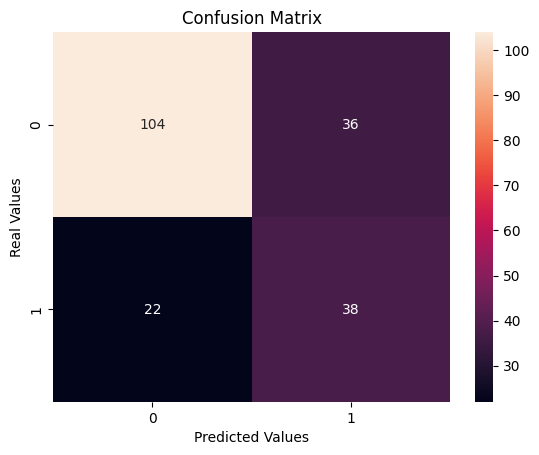

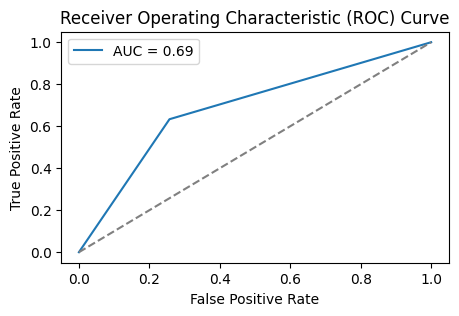

In [85]:
evaluate_classifier(y_test, final_predictions)

<b>The model presents a decent performance!</b>

<b>Recall Score (0.65):</b> The recall score (metric of interest for this analysis), also known as the true positive rate or sensitivity, measures the proportion of actual positive cases (bad risk customers) that the model correctly identifies. The model correctly identifies 65% of the bad risk customers. In practical terms, looking at the confusion matrix, this means that it has defined correctly 39 out of 60 bad risk customers.

<b>Precision Score (0.53):</b> The precision score quantifies the proportion of correctly predicted positive cases (bad risk customers) out of all instances predicted as positive by the model. Out of all the customers predicted as bad risk, 53% of them actually belong to this class. In practical terms, looking at the confusion matrix, this means that from 74 clients predicted as bad risk, 39 of them are actually risky. Thus, the precision score is not so good. However, predicting good risk customers as bad risk (false positives) will not cause many issues for the bank. Our goal is really to correctly identify a significant portion of bad risk customers, and the model does it.

<b>AUC Score (0.70):</b> The AUC (Area Under the Curve) score represents the overall performance of the model in distinguishing between positive (bad risk) and negative (good risk) instances. It measures the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance. A higher AUC score indicates better performance. With an AUC score of 0.70, the model demonstrates a high ability to differentiate between good and bad risk customers.

### Interpreting the model results with feature importances
I will look at <b>feature importances</b> below, in order to interpret Random Forest results. An important task when performing supervised learning on a dataset is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do.

Random Forest calculates feature importances by aggregating the average decrease in impurity (Gini or entropy) across all decision trees in the ensemble. Features that lead to more significant impurity reduction when used for splitting are considered more important. The final importance scores are normalized to sum up to 1 across all features. 

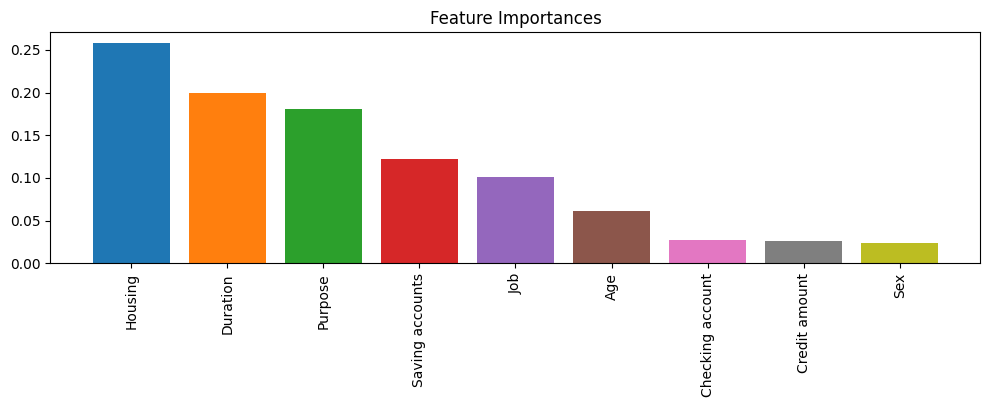

In [86]:
plot_feature_importances(final_rf_clf, df)

Housing, Duration, Purpose, Saving accounts and Job are the 5 features with the highest predictive power. I saw on the eda that customers within some Housing, Purpose, Job and Saving accounts categories like free, vacation/others, highly skilled and little presented a tendency of being any of the credit risk labels (bad or good). Furthermore, I also saw that longer durations credit services are associated with higher credit amounts and thus, higher levels of risk. 

Finally, considering this, the model results are consistent and interpretable. Everything makes sense.

### Precision vs Recall trade-off
- My objective in building the model is to correctly predict as many bad risk customers as possible, such that the bank can make informed decisions and minimize risk when offering its credit services. Thus, I will examine the precision-recall curve to determine whether there is room for enhancing the recall metric without significantly compromising the precision score. This is a typical procedure when handling an imbalanced target in binary classification. Finally, I will do the predictions comparing the estimated probabilities of being bad risk (positive) with the threshold that provides the target recall value. If the estimated probability is greater than the threshold, the instance will be classified as positive, else negative.
- <b>Precision-recall trade-off:</b> The precision-recall trade-off involves finding a balance between precision and recall in a classification model. For Random Forest, adjusting the decision threshold can impact this trade-off. Lowering the threshold increases recall but may decrease precision, while raising it has the opposite effect. This trade-off is crucial for optimizing model performance, especially when dealing with imbalanced datasets.

Getting the model's estimated probabilities.

In [87]:
predicted_probas = final_rf_clf.predict_proba(X_test_prepared)

Plotting precision recall curve for different threshold values.

In [90]:
precision, recall, threshold = precision_vs_recall_curve(y_test, predicted_probas)

NameError: name 'precision_vs_recall_curve' is not defined

There is space for enhancing the recall metric without significantly compromising the precision score.

Getting the threshold for a 0.8 recall score.

In [89]:
threshold_precision, threshold_recall, selected_threshold = get_threshold_metrics(precision=precision, 
recall=recall, threshold=threshold, 
target_metric='recall', target_metric_value=0.8)

NameError: name 'precision' is not defined

Making predictions.

In [ ]:
threshold_predictions = (predicted_probas[:, 1] >= selected_threshold).astype(int)

Evaluating final model after balancing the precision-recall trade-off.

              precision    recall  f1-score   support

           0       0.88      0.64      0.74       140
           1       0.49      0.80      0.61        60

    accuracy                           0.69       200
   macro avg       0.69      0.72      0.68       200
weighted avg       0.76      0.69      0.70       200



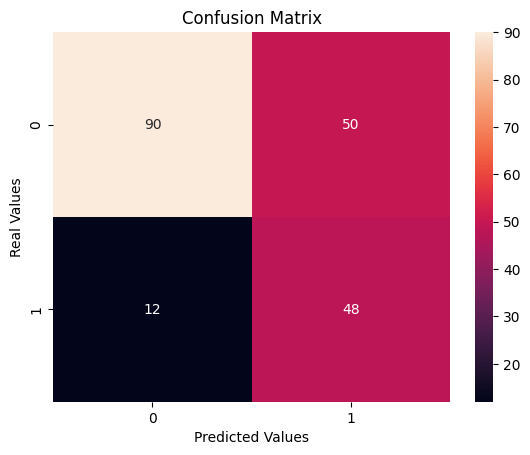

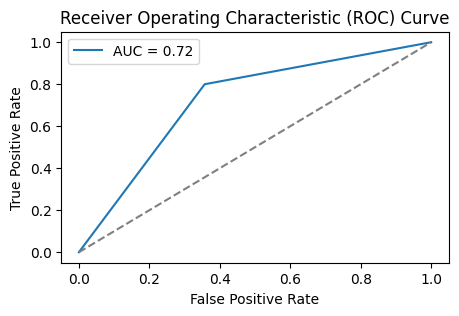

In [ ]:
evaluate_classifier(y_test, threshold_predictions)

The results are great! By dealing with precision-recall trade-off, I was able to select a threshold value that improved the recall metric from 0.65 to 0.8 while decreasing just a bit the precision score, from 0.51 to 0.49. In practical terms, looking at the confusion matrix, it was possible to correctly predict 48 of the 60 bad risk customers. At the same time, I could also improve the ROC-AUC score from 0.69 to 0.72. Finally, the objective was achieved. Now, the bank can correctly identify 80% of the bad risk customers. Thus, my model solves the business problem by allowing the bank to make informed decisions, balancing profit generation with prudent risk management.

### Visualizing the probabilities
Below I get the top 10 customers with respect to highest and lowest Random Forest model's estimated probabilities of being bad risk. As we can see, the model results are coherent! Sometimes it makes errors, but mostly it is correct with respect to risky clients.

Top 10 customers with highest model's estimated probabilities of being bad risk.

In [ ]:
bad_risk_probas = predicted_probas[:, 1]

probas_df = pd.concat([X_test, y_test], axis=1)
probas_df['Bad Risk Probas'] = bad_risk_probas
probas_df.sort_values(['Bad Risk Probas'], ascending=False).head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Bad Risk Probas
832,29,1,2,rent,little,little,11816,45,business,1,0.846043
887,23,1,2,own,little,moderate,15672,48,business,1,0.842016
11,24,0,2,rent,little,little,4308,48,business,1,0.828491
522,53,1,2,free,little,little,7119,48,furniture/equipment,1,0.807413
915,32,0,3,own,little,moderate,18424,48,vacation/others,1,0.806543
831,23,0,2,rent,little,little,1216,18,car,1,0.803602
375,37,0,2,rent,little,little,7685,48,business,1,0.787639
818,43,1,3,own,little,little,15857,36,vacation/others,0,0.783690
528,31,1,2,rent,little,little,2302,36,radio/TV,1,0.773189
570,23,0,1,rent,little,little,3234,24,furniture/equipment,1,0.767388


Top 10 customers with lowest model's estimated probabilities of being bad risk.

In [ ]:
probas_df.sort_values(['Bad Risk Probas'], ascending=True).head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Bad Risk Probas
234,42,1,1,own,little,NaN,1544,4,radio/TV,0,0.070008
551,45,1,1,own,quite rich,NaN,1750,6,radio/TV,0,0.080298
473,36,1,3,own,NaN,NaN,1238,6,education,0,0.086496
947,38,1,3,own,NaN,NaN,2859,12,car,0,0.090241
682,33,1,2,own,little,NaN,1478,15,radio/TV,0,0.101769
159,34,1,1,own,NaN,NaN,1898,6,radio/TV,0,0.102635
219,64,0,2,own,little,NaN,1364,10,car,0,0.119918
379,52,0,1,own,moderate,NaN,362,6,car,0,0.129222
725,41,0,1,own,rich,NaN,250,6,car,0,0.140357
115,47,1,2,own,NaN,NaN,3578,48,radio/TV,0,0.141960


# 8. Conclusions
- In this project, I have built a Random Forest Classifier model for predicting German Bank's customers credit risks. The objective of the project was to build a model that was able to correctly identify as many as possible bad risk customers, focusing on the recall score. 
- The exploratory data analysis (EDA) provided a bunch of patterns and insights that guided the modelling step and answered a lot of questions about the problem.
- The main techniques used to deal with the imbalanced target were stratified split, stratified k-fold cross validation, class weight Random Forest model hyperparameter and precision-recall trade-off balancing. I didn't intend to use SMOTE, because it is prone to overfitting and a lot of experient data scientists don't recommend it.
- First, I have reached a 0.65 recall score by applying hyperparameter tuning on Random Forest. Then, I looked at the precision-recall trade-off, finding a threshold that provided a recall of 0.8. I made the predictions again, now comparing the model's estimated probabilities of the customer being bad risk with this threshold. If the probability was greater than it, the instance was classified as positive, else negative. By doing this, the sensitivity in fact went from 0.65 to 0.8 without significantly compromising the precision metric, which went from 0.51 to 0.49, just a little downgrade, incredible!
- Overall, the scores suggest that the model provides valuable results for the bank in predicting customers credit risks. It identifies a high proportion of bad risk customers (80% of them, with a 0.8 recall score, the most important one for the analysis), has a decent proportion of correct predictions among the positive instances (0.49 precision score), and shows strong discrimination between bad and good risk customers (0.72 AUC score).
- Finally, the business problem was solved. I have found a lot of insights in the EDA step and built a model that is pretty useful for predicting customers credit risks. Now the bank can correctly identify 80% of the bad risk customers. Thus, it can make informed decisions, balancing profit generation with prudent risk management and minimizing potential financial losses caused when a borrower fails to repay a loan or a credit obligation.
- The next step is to deploy the model using CI/CD pipeline principles, with modular coding.

